<a href="https://colab.research.google.com/github/IagoGarciaSuarez/MachineLearningTechniques/blob/main/ML_Task_3_KNN_DT_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Getting Ready

In [1]:
!rm *.csv
!wget https://raw.githubusercontent.com/IagoGarciaSuarez/MachineLearningTechniques/main/insurance_dataset_train.csv
!wget https://raw.githubusercontent.com/IagoGarciaSuarez/MachineLearningTechniques/main/claimdesc.csv

--2022-01-22 13:23:06--  https://raw.githubusercontent.com/IagoGarciaSuarez/MachineLearningTechniques/main/insurance_dataset_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4942050 (4.7M) [text/plain]
Saving to: ‘insurance_dataset_train.csv’

insurance_dataset_t 100%[===================>]   4.71M  --.-KB/s    in 0.08s   

2022-01-22 13:23:06 (61.1 MB/s) - ‘insurance_dataset_train.csv’ saved [4942050/4942050]

--2022-01-22 13:23:06--  https://raw.githubusercontent.com/IagoGarciaSuarez/MachineLearningTechniques/main/claimdesc.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import neighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.stats.stats import pearsonr 

# 2. Reading the dataset
Having the dataset loaded, fields identification is needed to distinguish among feature variables and the target variable. The objective is to predict the amount of money that the insurance will be paying any worker in a given situation.
Therefore, here each feature of the dataset is explained:

- ClaimNumber: Unique policy identifier
- DateTimeOfAccident: Date and time of accident
- DateReported: Date that accident was reported
- Age: Age of worker
- Gender: Gender of worker
- MaritalStatus: Martial status of worker. (M)arried, (S)ingle, (U)unknown.
- DependentChildren: The number of dependent children
- DependentsOther: The number of dependants excluding children
- WeeklyWages: Total weekly wage
- PartTimeFullTime: Binary (P) or (F)
- HoursWorkedPerWeek: Total hours worked per week
- DaysWorkedPerWeek: Number of days worked per week
- ClaimDescription: Free text description of the claim
- InitialIncurredClaimCost: Initial estimate by the insurer of the claim cost
- **UltimateIncurredClaimCost**: Total claims payments by the insurance company. This is the field you are asked to predict in the test set.


In [4]:
df = pd.read_csv("insurance_dataset_train.csv")
claimdesc_df = pd.read_csv("claimdesc.csv")

df = pd.concat([df, claimdesc_df["transf_text"]], axis=1)
df.rename(columns={"InitialIncurredCalimsCost": "InitialIncurredClaimsCost"}, inplace=True) #Orthography error fix
df

,ClaimNumber,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,InitialIncurredClaimsCost,UltimateIncurredClaimCost,transf_text
0,WC8205482,2002-04-09T07:00:00Z,2002-07-05T00:00:00Z,48,M,M,0,0,500.00,F,38.0,5,LIFTING TYRE INJURY TO RIGHT ARM AND WRIST INJURY,1500,4748.203388,lift tyre injury right arm wrist injury
1,WC6922469,1999-01-07T11:00:00Z,1999-01-20T00:00:00Z,43,F,M,0,0,509.34,F,37.5,5,STEPPED AROUND CRATES AND TRUCK TRAY FRACTURE ...,5500,6326.285819,step around crate truck tray fracture leave fo...
2,WC5442654,1996-03-25T00:00:00Z,1996-04-14T00:00:00Z,30,M,U,0,0,709.10,F,38.0,5,CUT ON SHARP EDGE CUT LEFT THUMB,1700,2293.949087,cut sharp edge cut leave thumb
3,WC9796897,2005-06-22T13:00:00Z,2005-07-22T00:00:00Z,41,M,S,0,0,555.46,F,38.0,5,DIGGING LOWER BACK LOWER BACK STRAIN,15000,17786.487170,dig lower back lower back strain
4,WC2603726,1990-08-29T08:00:00Z,1990-09-27T00:00:00Z,36,M,M,0,0,377.10,F,38.0,5,REACHING ABOVE SHOULDER LEVEL ACUTE MUSCLE STR...,2800,4014.002925,reach shoulder level acute muscle strain leave...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36171,WC5624756,1996-05-29T09:00:00Z,1996-06-27T00:00:00Z,20,F,S,0,0,344.16,F,40.0,5,WALKED INTO DOOR BRUISED LEFT KNEE PAIN,1400,1343.054886,walk door bruise leave knee pain
36172,WC8516685,2002-10-08T08:00:00Z,2003-02-07T00:00:00Z,35,M,M,0,0,1668.83,F,71.0,7,LIFTING HOT WATER FROM TRAY BURN LEFT WRIST,1000,172876.632600,lift hot water tray burn leave wrist
36173,WC6891668,1999-09-22T09:00:00Z,1999-11-11T00:00:00Z,52,F,M,0,0,204.87,P,20.0,4,REMOVING BROKEN GLASS LACERATED LEFT THUMB,500,632.281472,remove break glass lacerate leave thumb
36174,WC4287842,1993-02-05T06:00:00Z,1993-03-19T00:00:00Z,28,M,M,0,0,730.87,F,38.0,5,FELL OVER SPRAINED ANKLE AND KNEE INJURY,4000,6714.495760,fell sprain ankle knee injury


# 3. Preprocessing
A consistent dataset is needed to do any prediction labor, so first of all, nulls are needed to be dropped.

In [5]:
pd.isnull(df).any()

ClaimNumber                  False
DateTimeOfAccident           False
DateReported                 False
Age                          False
Gender                       False
MaritalStatus                 True
DependentChildren            False
DependentsOther              False
WeeklyWages                   True
PartTimeFullTime             False
HoursWorkedPerWeek            True
DaysWorkedPerWeek            False
ClaimDescription             False
InitialIncurredClaimsCost    False
UltimateIncurredClaimCost    False
transf_text                  False
dtype: bool

In [6]:
df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
df

,ClaimNumber,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,InitialIncurredClaimsCost,UltimateIncurredClaimCost,transf_text
0,WC8205482,2002-04-09T07:00:00Z,2002-07-05T00:00:00Z,48,M,M,0,0,500.00,F,38.0,5,LIFTING TYRE INJURY TO RIGHT ARM AND WRIST INJURY,1500,4748.203388,lift tyre injury right arm wrist injury
1,WC6922469,1999-01-07T11:00:00Z,1999-01-20T00:00:00Z,43,F,M,0,0,509.34,F,37.5,5,STEPPED AROUND CRATES AND TRUCK TRAY FRACTURE ...,5500,6326.285819,step around crate truck tray fracture leave fo...
2,WC5442654,1996-03-25T00:00:00Z,1996-04-14T00:00:00Z,30,M,U,0,0,709.10,F,38.0,5,CUT ON SHARP EDGE CUT LEFT THUMB,1700,2293.949087,cut sharp edge cut leave thumb
3,WC9796897,2005-06-22T13:00:00Z,2005-07-22T00:00:00Z,41,M,S,0,0,555.46,F,38.0,5,DIGGING LOWER BACK LOWER BACK STRAIN,15000,17786.487170,dig lower back lower back strain
4,WC2603726,1990-08-29T08:00:00Z,1990-09-27T00:00:00Z,36,M,M,0,0,377.10,F,38.0,5,REACHING ABOVE SHOULDER LEVEL ACUTE MUSCLE STR...,2800,4014.002925,reach shoulder level acute muscle strain leave...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36171,WC5624756,1996-05-29T09:00:00Z,1996-06-27T00:00:00Z,20,F,S,0,0,344.16,F,40.0,5,WALKED INTO DOOR BRUISED LEFT KNEE PAIN,1400,1343.054886,walk door bruise leave knee pain
36172,WC8516685,2002-10-08T08:00:00Z,2003-02-07T00:00:00Z,35,M,M,0,0,1668.83,F,71.0,7,LIFTING HOT WATER FROM TRAY BURN LEFT WRIST,1000,172876.632600,lift hot water tray burn leave wrist
36173,WC6891668,1999-09-22T09:00:00Z,1999-11-11T00:00:00Z,52,F,M,0,0,204.87,P,20.0,4,REMOVING BROKEN GLASS LACERATED LEFT THUMB,500,632.281472,remove break glass lacerate leave thumb
36174,WC4287842,1993-02-05T06:00:00Z,1993-03-19T00:00:00Z,28,M,M,0,0,730.87,F,38.0,5,FELL OVER SPRAINED ANKLE AND KNEE INJURY,4000,6714.495760,fell sprain ankle knee injury


Some columns have an implicit realistic range, so in order to find those samples where these values may be wrong, a range of each of these columns will be displayed.

In [7]:
print(f'Age range: ({df["Age"].min()}, {df["Age"].max()})')
print(f'HoursWorkedPerWeek range: ({df["HoursWorkedPerWeek"].min()}, {df["HoursWorkedPerWeek"].max()})')
print(f'DaysWorkedPerWeek range: ({df["DaysWorkedPerWeek"].min()}, {df["DaysWorkedPerWeek"].max()})')

Age range: (13, 79)
HoursWorkedPerWeek range: (0.0, 640.0)
DaysWorkedPerWeek range: (1, 7)


A week has a maximum of 168 hours, therefore theres an evident error in some samples regarding the hours worked per week. Those samples need to be dropped too.

In [8]:
df.drop(df[df["HoursWorkedPerWeek"]>=168].index, inplace=True)
df.reset_index(drop = True, inplace = True)
print(f'HoursWorkedPerWeek range: ({df["HoursWorkedPerWeek"].min()}, {df["HoursWorkedPerWeek"].max()})')


HoursWorkedPerWeek range: (0.0, 93.0)


Now, the algorithm requires numeric values, so categorial fields like Gender, MaritalStatus and PartTimeFullTime need to be encoded, and the ClaimDescription feature will be ignored until a text processing is done. OneHotEncoder will be used for this step.

## 3.1. Removing non-numerical columns

In [9]:
df_OneHot = pd.get_dummies(df[['Gender','MaritalStatus', 'PartTimeFullTime']])
insurance_df = df.drop(labels=['Gender', 'MaritalStatus', 'PartTimeFullTime', 'ClaimDescription', 'ClaimNumber', 'DateTimeOfAccident', 'DateReported', 'transf_text'], axis=1)
insurance_df = pd.concat([insurance_df, df_OneHot], axis = 1)
insurance_df

,Age,DependentChildren,DependentsOther,WeeklyWages,HoursWorkedPerWeek,DaysWorkedPerWeek,InitialIncurredClaimsCost,UltimateIncurredClaimCost,Gender_F,Gender_M,Gender_U,MaritalStatus_M,MaritalStatus_S,MaritalStatus_U,PartTimeFullTime_F,PartTimeFullTime_P
0,48,0,0,500.00,38.0,5,1500,4748.203388,0,1,0,1,0,0,1,0
1,43,0,0,509.34,37.5,5,5500,6326.285819,1,0,0,1,0,0,1,0
2,30,0,0,709.10,38.0,5,1700,2293.949087,0,1,0,0,0,1,1,0
3,41,0,0,555.46,38.0,5,15000,17786.487170,0,1,0,0,1,0,1,0
4,36,0,0,377.10,38.0,5,2800,4014.002925,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36017,20,0,0,344.16,40.0,5,1400,1343.054886,1,0,0,0,1,0,1,0
36018,35,0,0,1668.83,71.0,7,1000,172876.632600,0,1,0,1,0,0,1,0
36019,52,0,0,204.87,20.0,4,500,632.281472,1,0,0,1,0,0,0,1
36020,28,0,0,730.87,38.0,5,4000,6714.495760,0,1,0,1,0,0,1,0


## 3.2. Claim description processing

The description text is read from a dataset already created. This dataset has the original description and the processed text.

In [15]:
claimdesc_df = df[["transf_text", "UltimateIncurredClaimCost"]]
claimdesc_df

,transf_text,UltimateIncurredClaimCost
0,lift tyre injury right arm wrist injury,4748.203388
1,step around crate truck tray fracture leave fo...,6326.285819
2,cut sharp edge cut leave thumb,2293.949087
3,dig lower back lower back strain,17786.487170
4,reach shoulder level acute muscle strain leave...,4014.002925
...,...,...
36017,walk door bruise leave knee pain,1343.054886
36018,lift hot water tray burn leave wrist,172876.632600
36019,remove break glass lacerate leave thumb,632.281472
36020,fell sprain ankle knee injury,6714.495760


A TF-IDF dataframe is created from this data.

In [16]:
vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True)
data = vectorizer.fit_transform(claimdesc_df['transf_text'])
claimdesc_tfidf = pd.DataFrame(data.toarray(), columns=vectorizer.get_feature_names())
claimdesc_tfidf

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,abalone,abcess,abdomin,abdominal,abnormally,abrasion,abrasions,abscess,access,acci,accident,accidentally,accidently,acetylene,ache,achilles,acid,acidic,acoustic,across,action,acute,adaptor,additive,adhesive,adjacent,adjust,aerial,aeroplane,aggravate,aggravation,aggressive,agitator,air,aircraft,albow,algae,alight,aligner,alkaline,...,window,windows,windscreen,windy,wine,wipe,wiper,wire,wisted,within,witness,wizz,wobbly,wok,wood,woodchip,wooden,woodwork,woodworking,wool,word,work,workbench,worker,workplace,workshop,workstation,wrap,wrapper,wrench,wrestle,wrist,wrists,write,wrong,yard,yarn,yoghurt,zinc,zipper
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.321341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.396283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.301894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 4. Exploring the data
Now that the dataframe is adapted to the objective needs, it will be explored to find the best way to attach the problem.

## 4.1. Histograms
Using histograms it's possible to analyze the number of occurrences for each feature. 

Histograms will be plotted to show each person personal data, working conditions and economic situation.

In [10]:
insurance_df

,Age,DependentChildren,DependentsOther,WeeklyWages,HoursWorkedPerWeek,DaysWorkedPerWeek,InitialIncurredClaimsCost,UltimateIncurredClaimCost,Gender_F,Gender_M,Gender_U,MaritalStatus_M,MaritalStatus_S,MaritalStatus_U,PartTimeFullTime_F,PartTimeFullTime_P
0,48,0,0,500.00,38.0,5,1500,4748.203388,0,1,0,1,0,0,1,0
1,43,0,0,509.34,37.5,5,5500,6326.285819,1,0,0,1,0,0,1,0
2,30,0,0,709.10,38.0,5,1700,2293.949087,0,1,0,0,0,1,1,0
3,41,0,0,555.46,38.0,5,15000,17786.487170,0,1,0,0,1,0,1,0
4,36,0,0,377.10,38.0,5,2800,4014.002925,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36017,20,0,0,344.16,40.0,5,1400,1343.054886,1,0,0,0,1,0,1,0
36018,35,0,0,1668.83,71.0,7,1000,172876.632600,0,1,0,1,0,0,1,0
36019,52,0,0,204.87,20.0,4,500,632.281472,1,0,0,1,0,0,0,1
36020,28,0,0,730.87,38.0,5,4000,6714.495760,0,1,0,1,0,0,1,0


### 4.1.1. Personal Data Histograms

About the personal data for each sample, it's possible to say that the most affected people is around 20-30 years old males, while it is possible and not very rare to find extremely young workers (10-20 years old) and some very old workers, around the age of 70-80 years old.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2c875048d0>,
      dtype=object)

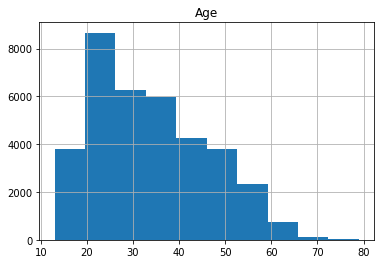

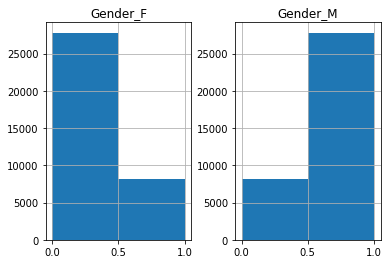

In [11]:
insurance_df[["Age"]].hist()
insurance_df[["Gender_F", "Gender_M"]].hist(bins=2)

### 4.1.2. Working Conditions Histograms

Regarding the working conditions, the highest probability of having an accident happens when the person works 5 days per week, with a total 40 hours weekly. This result is probably highly influenced by the fact that most of the insured people work full time.

In the other hand, it's highly uncommon to find accidented people who work any other number of days or hours.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2c86ea8dd0>,
      dtype=object)

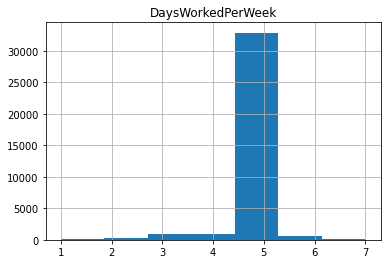

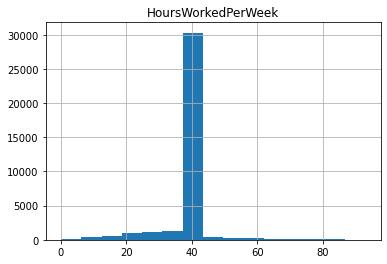

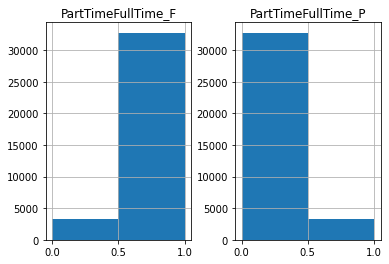

In [12]:
insurance_df[["DaysWorkedPerWeek"]].hist(bins=7)
insurance_df[["HoursWorkedPerWeek"]].hist(bins=15, range=(0, 93))
insurance_df[["PartTimeFullTime_F", "PartTimeFullTime_P"]].hist(bins=2)

### 4.1.3. Economic Factors

Here, some weekly wages may seem unrealistic as they can go higher than 5000, and assuming the currency is the dollar or the euro, and taking into account that most of the wages are between 0 and 1000, it's highly probable that this could be an error. Even though, no currency is stated in the description, nor details which could confirm this cases as errors, so they will be left in the dataset.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2c86b8b910>,
      dtype=object)

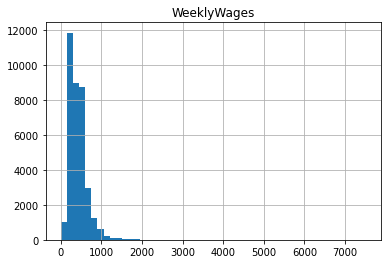

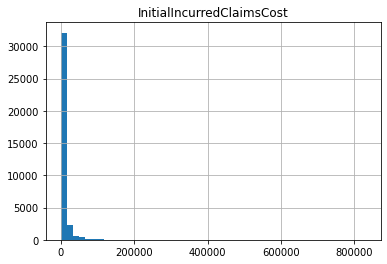

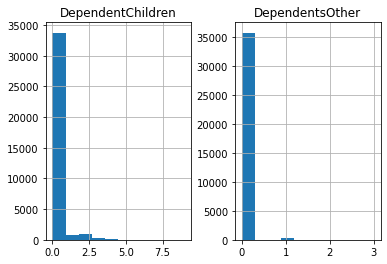

In [13]:
insurance_df[["WeeklyWages"]].hist(bins=50)
insurance_df[["InitialIncurredClaimsCost"]].hist(bins=50)
insurance_df[["DependentChildren", "DependentsOther"]].hist()

## 4.2. Correlation Diagram


Having analyzed the histograms, it's time to find the Pearson's Coefficient for some of the values shown above. 
- Age
- Gender_M (no need to calculate for both genders)
- Hours/Week (corresponds to HoursWorkedPerWeek value)
- WeeklyWages
- IniIncClaimsCost (corresponds to InitialIncurredClaimsCost)
- DepenChildren (corresponds to DependentChildren)
- DepenOther (corresponds to DependentsOther)

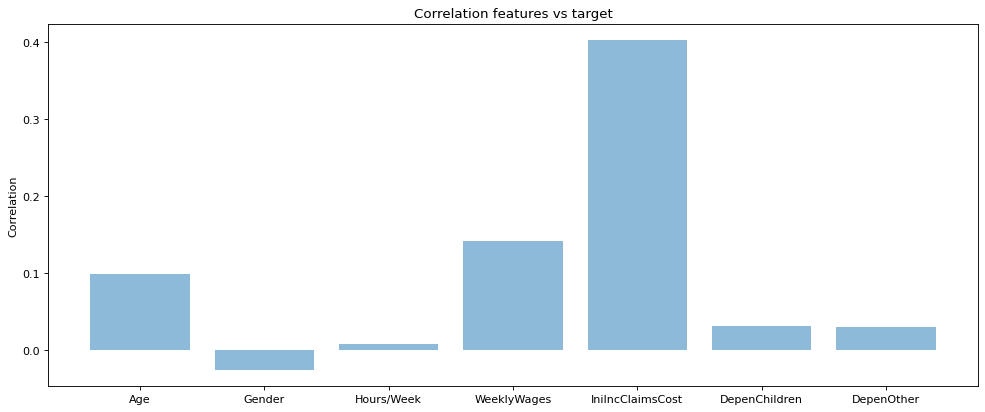

[0.09843266073663377,
 -0.02596335978660124,
 0.007027647370186733,
 0.14072219960663074,
 0.4019362422266518,
 0.03140536485623805,
 0.030060217135795562]

In [14]:
corr = [pearsonr(insurance_df['Age'], insurance_df['UltimateIncurredClaimCost'])[0], 
        pearsonr(insurance_df['Gender_M'], insurance_df['UltimateIncurredClaimCost'])[0],
        pearsonr(insurance_df['HoursWorkedPerWeek'], insurance_df['UltimateIncurredClaimCost'])[0],
        pearsonr(insurance_df['WeeklyWages'], insurance_df['UltimateIncurredClaimCost'])[0],
        pearsonr(insurance_df['InitialIncurredClaimsCost'], insurance_df['UltimateIncurredClaimCost'])[0],
        pearsonr(insurance_df['DependentChildren'], insurance_df['UltimateIncurredClaimCost'])[0],
        pearsonr(insurance_df['DependentsOther'], insurance_df['UltimateIncurredClaimCost'])[0]]

features= ('Age', 'Gender', 'Hours/Week', "WeeklyWages", "IniIncClaimsCost", 
           "DepenChildren", "DepenOther")
y_pos = np.arange(len(features))
 
figure(figsize=(15, 6), dpi=80)

plt.bar(y_pos, corr, align='center', alpha=0.5)
plt.xticks(y_pos, features)
plt.ylabel('Correlation')
plt.title('Correlation features vs target')

plt.show()

corr

*Doubt: Why shouldn't I use more than the 3 most correlated variables? Once the error is calculated, the error is higher if any other feature selection is done but, shouldn't it be the other way? With more data, shouldn't the prediction be more accurate? Would it be overfitting?*

Looking at the correlation diagram, none of the chosen features is highly correlated with the objective, being the initial claim the one with the higher correlation with only 0.40 and followed by the weekly wages with 0.14.

# 5. Transformation

With the data preprocessed and explored, now it's time to split it into train data and test data. To do this, *selectKBest* algorithm is applied with k=10. Taking into account the results from the correlation diagram, it's spected to find *InitialIncurredClaimsCost*, *WeeklyWages* and *Age* among those best features.

In [17]:
x_features = ['InitialIncurredClaimsCost', 'WeeklyWages', 'Age']
ins_costwwagesage = insurance_df[x_features]
ins_costwwagesage

,InitialIncurredClaimsCost,WeeklyWages,Age
0,1500,500.00,48
1,5500,509.34,43
2,1700,709.10,30
3,15000,555.46,41
4,2800,377.10,36
...,...,...,...
36017,1400,344.16,20
36018,1000,1668.83,35
36019,500,204.87,52
36020,4000,730.87,28


Now, claim descriptions data is joined with the most relevant features found before.

In [22]:
ins_df=pd.concat([claimdesc_tfidf, ins_costwwagesage], axis=1)
ins_df

,abalone,abcess,abdomin,abdominal,abnormally,abrasion,abrasions,abscess,access,acci,accident,accidentally,accidently,acetylene,ache,achilles,acid,acidic,acoustic,across,action,acute,adaptor,additive,adhesive,adjacent,adjust,aerial,aeroplane,aggravate,aggravation,aggressive,agitator,air,aircraft,albow,algae,alight,aligner,alkaline,...,windy,wine,wipe,wiper,wire,wisted,within,witness,wizz,wobbly,wok,wood,woodchip,wooden,woodwork,woodworking,wool,word,work,workbench,worker,workplace,workshop,workstation,wrap,wrapper,wrench,wrestle,wrist,wrists,write,wrong,yard,yarn,yoghurt,zinc,zipper,InitialIncurredClaimsCost,WeeklyWages,Age
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.321341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1500,500.00,48
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5500,509.34,43
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1700,709.10,30
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15000,555.46,41
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.396283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2800,377.10,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1400,344.16,20
36018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.301894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000,1668.83,35
36019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,500,204.87,52
36020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,

In [110]:
k_best = SelectKBest(score_func=f_regression,k=10)
claimdesc_kbestfeat = k_best.fit_transform(ins_df,insurance_df['UltimateIncurredClaimCost'])
pd.DataFrame(claimdesc_kbestfeat)

,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.0,0.0,0.241589,0.0,0.000000,0.0,1500.0,500.00,48.0
1,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,5500.0,509.34,43.0
2,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,1700.0,709.10,30.0
3,0.472665,0.0,0.0,0.000000,0.0,0.217439,0.0,15000.0,555.46,41.0
4,0.000000,0.0,0.0,0.000000,0.0,0.121668,0.0,2800.0,377.10,36.0
...,...,...,...,...,...,...,...,...,...,...
36017,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,1400.0,344.16,20.0
36018,0.000000,0.0,0.0,0.226968,0.0,0.000000,0.0,1000.0,1668.83,35.0
36019,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,500.0,204.87,52.0
36020,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,4000.0,730.87,28.0


In [140]:
ins_kbest = pd.DataFrame(claimdesc_kbestfeat)
ins_kbest_results = pd.concat([ins_kbest, insurance_df['UltimateIncurredClaimCost']], axis=1)
ins_kbest_results

,0,1,2,3,4,5,6,7,8,9,UltimateIncurredClaimCost
0,0.000000,0.0,0.0,0.241589,0.0,0.000000,0.0,1500.0,500.00,48.0,4748.203388
1,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,5500.0,509.34,43.0,6326.285819
2,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,1700.0,709.10,30.0,2293.949087
3,0.472665,0.0,0.0,0.000000,0.0,0.217439,0.0,15000.0,555.46,41.0,17786.487170
4,0.000000,0.0,0.0,0.000000,0.0,0.121668,0.0,2800.0,377.10,36.0,4014.002925
...,...,...,...,...,...,...,...,...,...,...,...
36017,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,1400.0,344.16,20.0,1343.054886
36018,0.000000,0.0,0.0,0.226968,0.0,0.000000,0.0,1000.0,1668.83,35.0,172876.632600
36019,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,500.0,204.87,52.0,632.281472
36020,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,4000.0,730.87,28.0,6714.495760


This dataframe is saved to be used in hyperparameter optimization and boosting notebooks.

In [141]:
ins_kbest_results.to_csv("ins_10best_results.csv")

# 6. Baseline: Knn and Decision Trees

## 6.1. kNN

The split of the data into train and test set is performed.

In [112]:
X_train, X_test, y_train, y_test = train_test_split(ins_kbest, insurance_df['UltimateIncurredClaimCost'], test_size=0.33, random_state=42)
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

To find the best value of K, a model will be trained for each value from 1 to 100 and then their accuracy will be compared using MAE as the error metric. The weights will also be tested and both results will be plotted.

Min Value uniform : 7572.337394618825 (49)
Min Value distance : 7694.053648154033 (49)


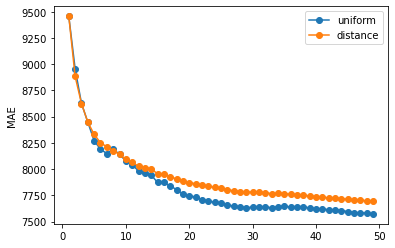

In [65]:
cv = KFold(n_splits = 10, shuffle = False) #

cv_dt_train_df = X_train.assign(cost=y_train)

for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,50):
       fold_accuracy = []
       knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
       for train_fold, test_fold in cv.split(cv_dt_train_df):
          # División train test aleatoria
          f_train = cv_dt_train_df.loc[train_fold]
          f_test = cv_dt_train_df.loc[test_fold]
          # entrenamiento y ejecución del modelo
          knn.fit( X = f_train.drop(['cost'], axis=1), 
                               y = f_train['cost'])
          y_pred = knn.predict(X = f_test.drop(['cost'], axis = 1))
          # evaluación del modelo
          mae = mean_absolute_error(f_test['cost'], y_pred)
          fold_accuracy.append(mae)
       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
   plt.plot(range(1,len(total_scores)+1), total_scores, 
             marker='o', label=weights)
   print ('Min Value ' +  weights + " : " +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
   plt.ylabel('MAE')      
    

plt.legend()
plt.show() 

*Doubt: The results above may indicate that insurance policies changed over time?*

Now it's possible to choose K more accurately from the results above. When the number of neighbours is <INSERTAR AQUÍ K OBTENIDO> the prediction is more accurate. After this point, MAE keeps decreasing, but with diminishing returns, so this value will be the selected one with uniform weights.

MSE, MAE and R^2 metris are checked. The three of them are not good. With hyperparameter optimization and boosting, better values will be tried to be found.

In [113]:
n_neighbors = 250
weights = 'uniform'
knn = neighbors.KNeighborsRegressor(n_neighbors= n_neighbors, weights=weights) 
knn.fit( X = X_train, y = y_train)
y_pred = knn.predict(X = X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('MSE =', mse)
print('MAE =', mae)
print('R^2 =', r2)

MSE = 568861126.2888885
MAE = 7612.032722345033
R^2 = 0.292986303606803


*Doubt: What does the error value mean exactly? The higher, the less accuracy, but what does the value itself depend on? Is this related to the metric used in the objective values? if objective value is represented as 9 ciphers numbers, the error would be greater than if it were reprsented as 2 ciphers numbers?*

The model is trained, so it can be applied to the test data. Below, a sample of this prediction is shown. To make it readable, it's been restricted to 300 results. As expected, the model doesn't fit well, but it's clearly better for average values than outlier values.

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


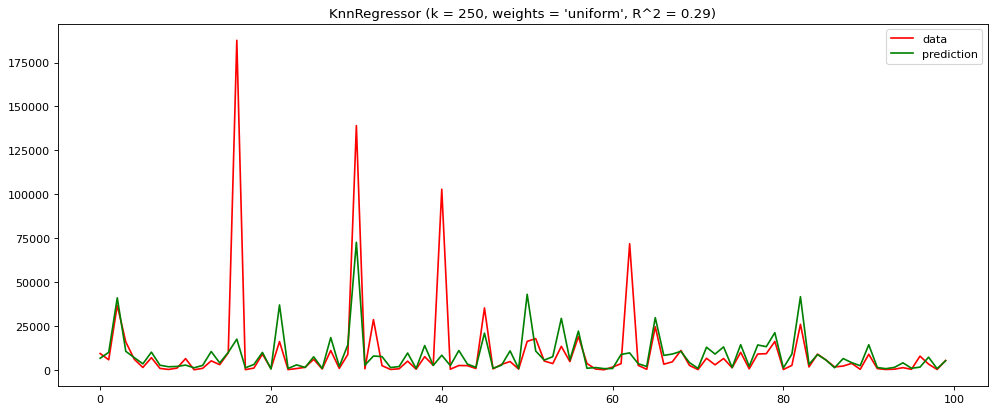

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


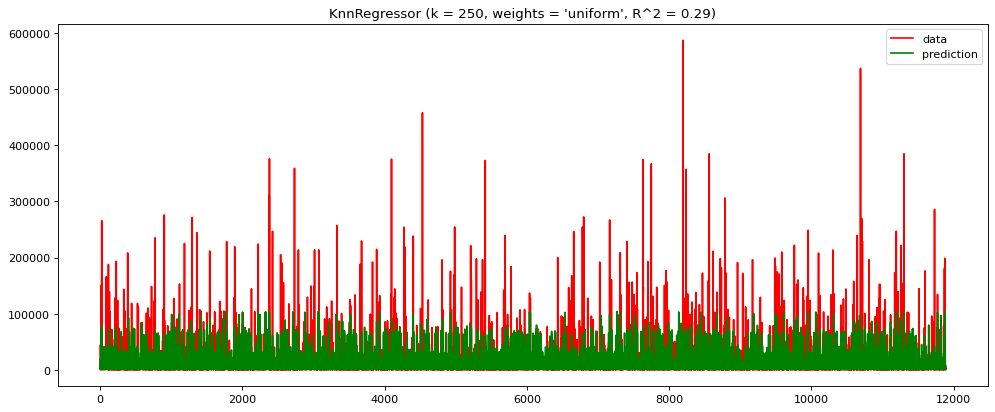

In [114]:
figure(figsize=(15, 6), dpi=80)

xx = np.stack(i for i in range(2000:2300))
y_test_plot = y_test[2000:2300]
plt.plot(xx, y_test_plot, c='r', label='data')
plt.plot(xx, y_pred[200:2300], c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("KnnRegressor (k = %i, weights = '%s', R^2 = %1.4f)" % (n_neighbors,weights, r2))

plt.show()

figure(figsize=(15, 6), dpi=80)

xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("KnnRegressor (k = %i, weights = '%s', R^2 = %1.4f)" % (n_neighbors,weights, r2))

plt.show()

## 6.2. Decision Tree

Using MAE as the criterion for the regressor, X_train and y_train are used to fit the model.

In [115]:
regressor = DecisionTreeRegressor(criterion='mae', random_state=0)
regressor.fit(X = X_train, y = y_train)

y_pred = regressor.predict(X = X_train)

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


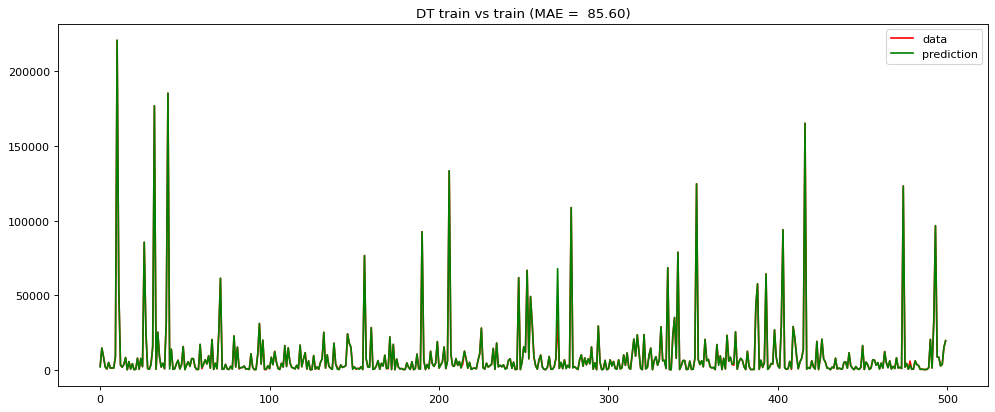

In [116]:
figure(figsize=(15, 6), dpi=80)

mae = mean_absolute_error(y_train, y_pred)
xx = np.stack(i for i in range(500))
y_train_plot = y_train[2000:2500]
plt.plot(xx, y_train_plot, c='r', label='data')
plt.plot(xx, y_pred[2000:2500], c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("DT train vs train (MAE = %6.2f)" % mae)
plt.show()

With a train vs test approach, the MAE is 85.60.

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


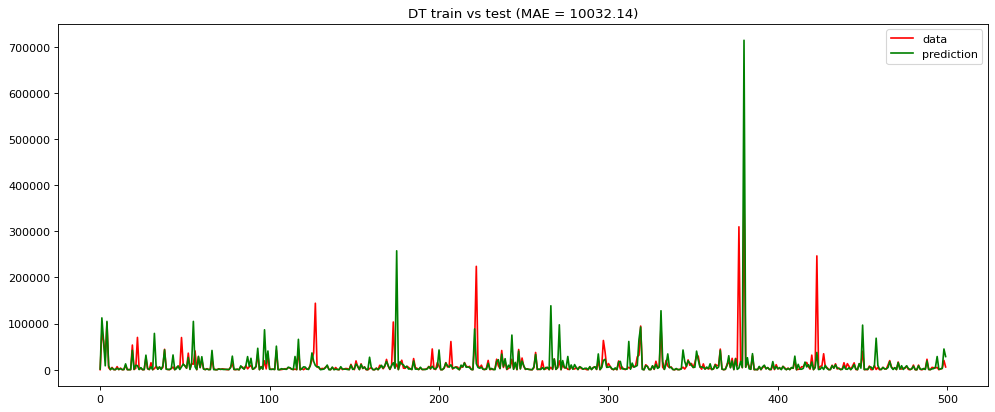

In [117]:
y_pred = regressor.predict(X = X_test)

figure(figsize=(15, 6), dpi=80)

xx = np.stack(i for i in range(500))
y_test_plot = y_test[2000:2500]
plt.plot(xx, y_test_plot, c='r', label='data')
plt.plot(xx, y_pred[2000:2500], c='g', label='prediction')
plt.axis('tight')
plt.legend()
mae = mean_absolute_error(y_test, y_pred)
plt.title("DT train vs test (MAE = %6.2f)" % mae)
plt.show()

With a train vs test aproach, MAE is 10032.14, which is very high. This could mean that the model is overfitting the train set.

For a better understanding of the results, feature relevancies are shown and, as expected, the three most correlated features found in the correlation diagram are among them.

In [118]:
print ('Feature Relevances')
pd.DataFrame({'Attributes': list(range(0, 7)) + ['InitialIncurredClaimsCost', 'WeeklyWages', 'Age'],
              'Decision Tree': regressor.feature_importances_})

Feature Relevances


,Attributes,Decision Tree
0,0,0.055240
1,1,0.017475
2,2,0.004669
3,3,0.036376
4,4,0.003736
5,5,0.072590
6,6,0.018780
7,InitialIncurredClaimsCost,0.499282
8,WeeklyWages,0.160122
9,Age,0.131729


In [119]:
cv_dt_train_df = X_train.assign(cost=y_train) # para hacer cv con diferentes sets
cv_dt_train_df.reset_index(drop = True, inplace = True)

Cross validation is performed in order to avoid overfitting.

Min Value 7444.228013648253 (55)


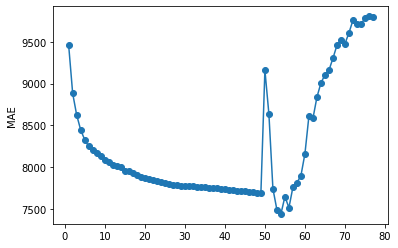

In [120]:
cv = KFold(n_splits = 10, shuffle = False) # 
for i in range(2, 30):
  regressor = DecisionTreeRegressor(max_depth=i)
  fold_accuracy = []

  for train_fold, test_fold in cv.split(cv_dt_train_df):
    # División train test aleatoria
    f_train = cv_dt_train_df.loc[train_fold]
    f_test = cv_dt_train_df.loc[test_fold]
    # entrenamiento y ejecución del modelo
    regressor.fit( X = f_train.drop(['cost'], axis=1), y = f_train['cost'])
    y_pred = regressor.predict(X = f_test.drop(['cost'], axis = 1))
    # evaluación del modelo
    mae = mean_absolute_error(f_test['cost'], y_pred)
    fold_accuracy.append(mae)
  total_scores.append(sum(fold_accuracy)/len(fold_accuracy))


max_depth = np.argmin(total_scores) + 2
print ('Min Value ' + str(min(total_scores)) +" (" + str(max_depth) + ")")

  
plt.plot(range(1,len(total_scores)+1), total_scores, 
         marker='o')
plt.ylabel('MAE')   

plt.show() 

The prediction results using the best max depth value obtained are plotted with a range of 300 values to make it more readable and with the whole samples range.

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


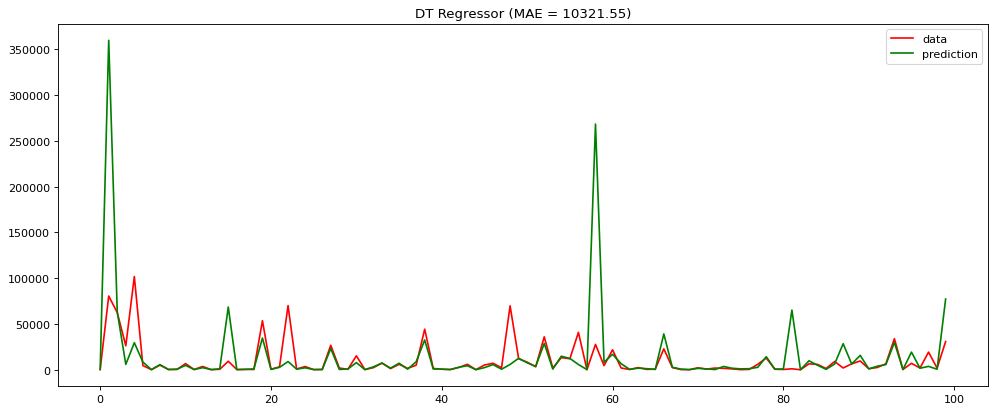

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


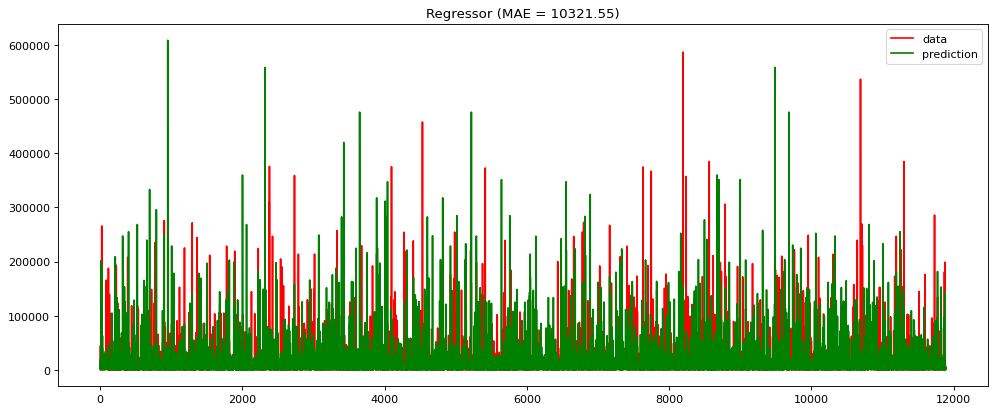

In [121]:
regressor = DecisionTreeRegressor(max_depth = 55)
regressor.fit(X_train, y_train)
pred_values = regressor.predict(X_test)
mae = mean_absolute_error(y_test,pred_values)

figure(figsize=(15, 6), dpi=80)

xx = np.stack(i for i in range(2000, 2300))
y_test_plot = y_test[2000:2300]
plt.plot(xx, y_test_plot, c='r', label='data')
plt.plot(xx, pred_values[2000:2300], c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("DT Regressor (MAE = %6.2f)" % mae)

plt.show()

figure(figsize=(15, 6), dpi=80)

xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='data')
plt.plot(xx, pred_values, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("Regressor (MAE = %6.2f)" % mae)
plt.show()



# 7. Optimized Model

## 7.1. Random Forest

A random forest regressor is used in order to improve the results obtained as they are highly imprecise.

In [130]:
X = ins_kbest
y = insurance_df['UltimateIncurredClaimCost']

X_train, X_test, y_train, y_test = train_test_split(ins_kbest, insurance_df['UltimateIncurredClaimCost'], test_size=0.4, random_state=42)
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)

In [131]:
regressor = RandomForestRegressor(n_estimators= 500, max_depth = 55, criterion='mae', random_state=0)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

mae = mean_absolute_error(y_test,y_pred)
print ("Error Measure ",  mae)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


Error Measure  8646.42025866881


In [133]:
r2 = r2_score(y_test, y_pred)
print("R^2 = ", r2)

R^2 =  0.0936955370417677


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


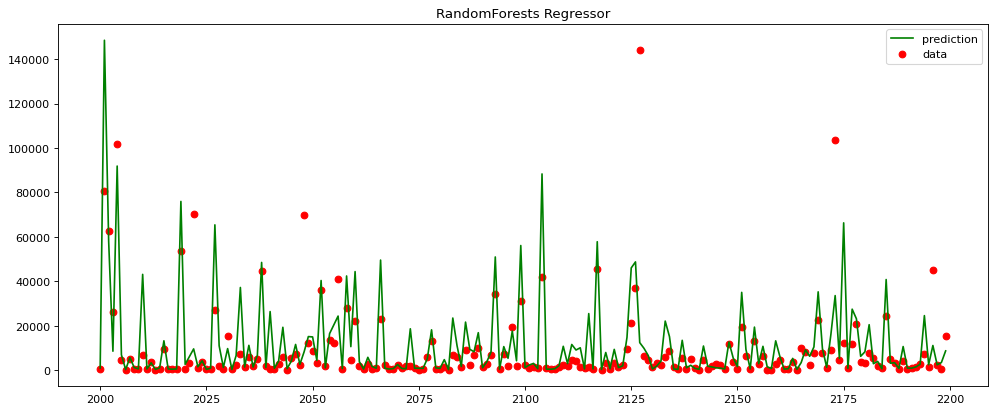

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


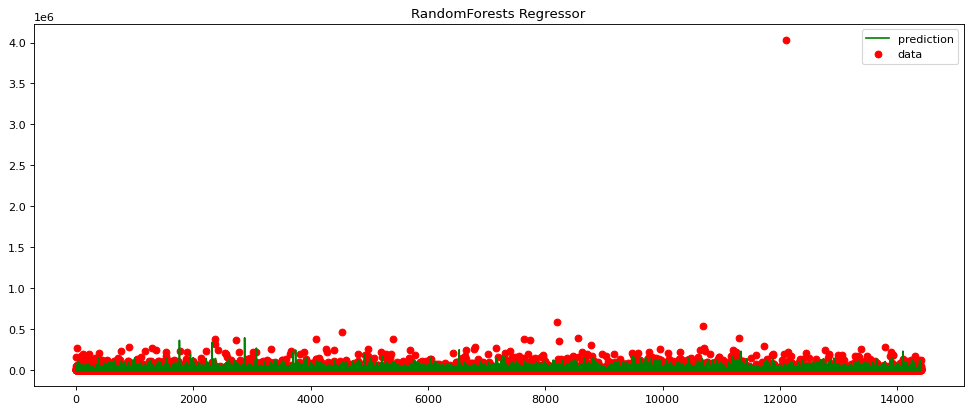

In [135]:
figure(figsize=(15, 6), dpi=80)

xx = np.stack(i for i in range(2000, 2200))
plt.scatter(xx, y_test[2000:2200], c='r', label='data')
plt.plot(xx, y_pred[2000:2200], c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("RandomForests Regressor (MAE = %6.2f, R^2 = %1.4f)" % (mae, r2))

plt.show()

figure(figsize=(15, 6), dpi=80)

xx = np.stack(i for i in range(len(y_test)))
plt.scatter(xx, y_test, c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("RandomForests Regressor (MAE = %6.2f, R^2 = %1.4f)" % (mae, r2))

plt.show()